In [17]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os

import xgboost as xgb

import networkx as nx
import pdb
import pickle

from pandas import HDFStore,DataFrame
from pandas import read_hdf

import gc
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import f1_score

In [2]:
if not os.path.isfile('FacebookRecruiting/train_woheader.csv'):
    traincsv = pd.read_csv('FacebookRecruiting/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('FacebookRecruiting/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('FacebookRecruiting/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Name: 
Type: DiGraph
Number of nodes: 26
Number of edges: 20
Average in degree:   0.7692
Average out degree:   0.7692


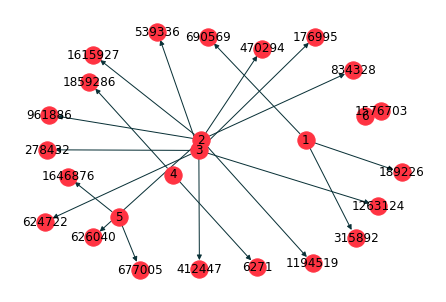

In [3]:
#Displaying subgraph
if not os.path.isfile('FacebookRecruiting/train_woheader_subgraph.csv'):
    pd.read_csv('FacebookRecruiting/train.csv', nrows=20).to_csv('train_woheader_subgraph.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_subgraph.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#FF3342',edge_color='#093137',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("subraph.pdf")
print(nx.info(subgraph))

## EXPLORATORY DATA ANALYSIS

In [4]:
print("Number of unique persons",len(g.nodes()))

Number of unique persons 1862220


### No of followers:

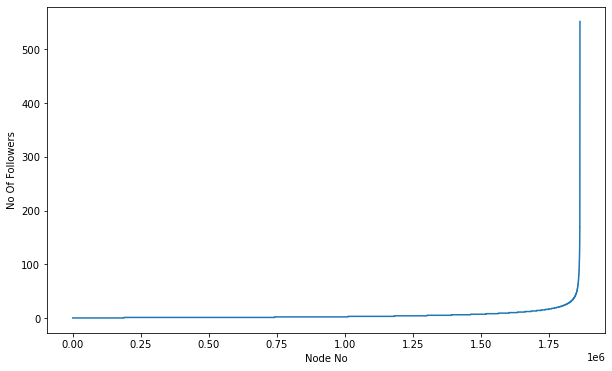

In [5]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Node No')
plt.ylabel('No Of Followers')
plt.show()

From the above graph we can see that only some users have too many followers.

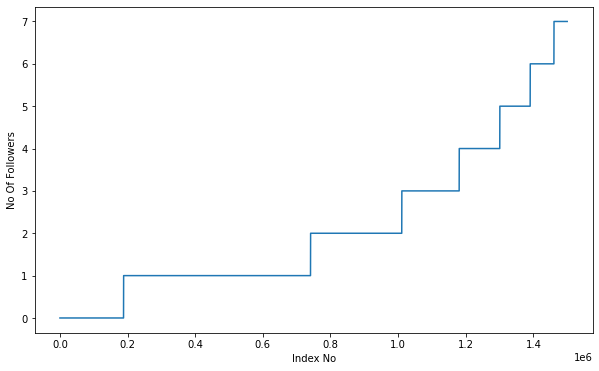

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In [7]:
#90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


We can see that 99% users have less than 40 followers.

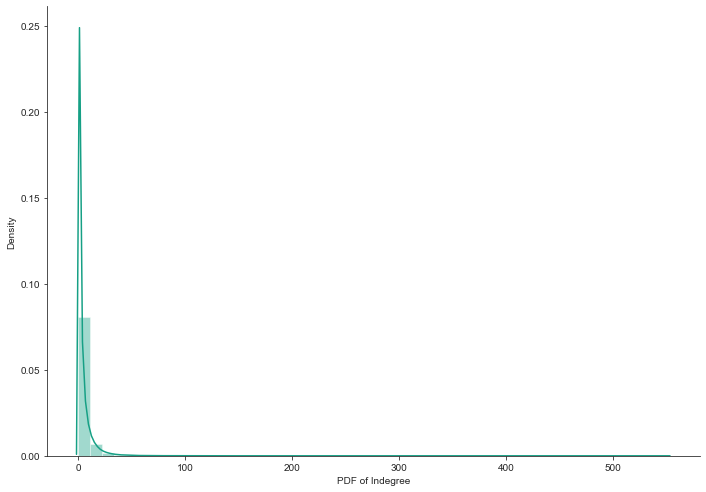

In [8]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()

### No of users each person is following

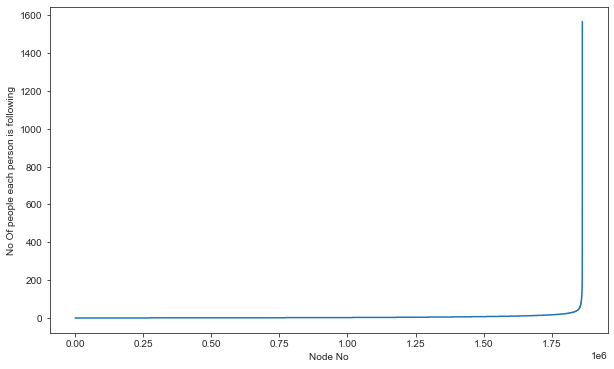

In [9]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Node No')
plt.ylabel('No Of people each person is following')
plt.show()

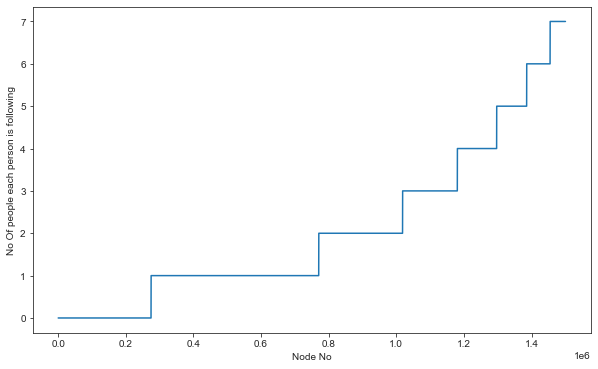

In [10]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Node No')
plt.ylabel('No Of people each person is following')
plt.show()

In [11]:
#90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [12]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


Almost all nodes have degree less than 100

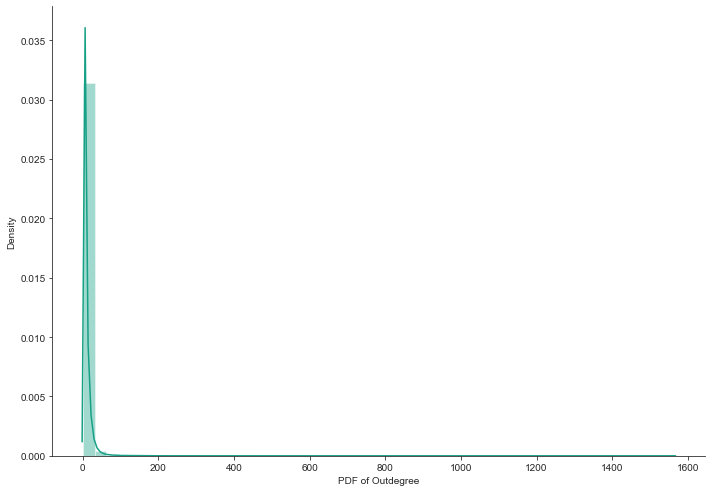

In [13]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [14]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and their percentage is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and their percentage is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not following anyone and also not having any followers are',count)

No of persons those are not following anyone are 274512 and their percentage is 14.741115442858524
No of persons having zero followers are 188043 and their percentage is 10.097786512871734
No of persons those are not following anyone and also not having any followers are 0


### Followers and Followees

In [15]:

from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

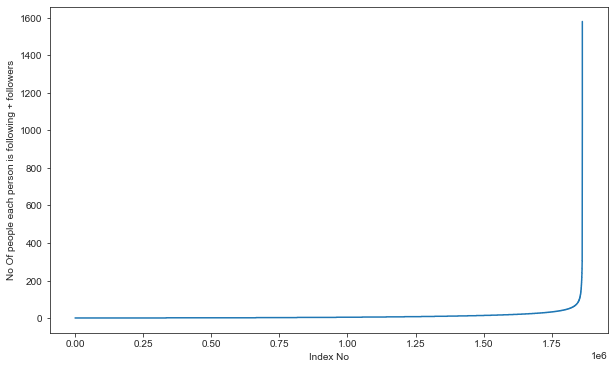

In [16]:

in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

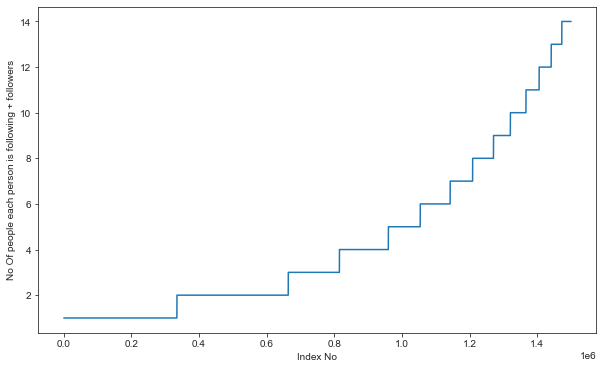

In [17]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [18]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


Almost all users have No of followers + followee less than 80

In [19]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [20]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

Min of no of followers + following is 1
334291  persons having minimum no of followers + following
Max of no of followers + following is 1579
1  persons having maximum no of followers + following
No of persons having followers + following less than 10 are 1320326
No of weakly connected components 45558
weakly connected components with 2 nodes 32195


### GENERATING EDGES WHICH ARE NOT PRESENT IN THE GRAPH


Generated Bad links from graph which are not in graph and whose shortest path is greater than 2.

In [2]:
import random
if not os.path.isfile('FacebookRecruiting/missing_edges.p'):
    r = csv.reader(open('FacebookRecruiting/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
             
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('FacebookRecruiting/missing_edges.p','wb'))
else:
    missing_edges = pickle.load(open('FacebookRecruiting/missing_edges.p','rb'))

### TRAIN-TEST-SPLIT

In [3]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('FacebookRecruiting/train_pos_after_eda.csv')) and (not os.path.isfile('FacebookRecruiting/test_pos_after_eda.csv')):
    
    df_pos = pd.read_csv('FacebookRecruiting/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*70)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*70)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    X_train_pos.to_csv('FacebookRecruiting/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('FacebookRecruiting/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('FacebookRecruiting/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('FacebookRecruiting/test_neg_after_eda.csv',header=False, index=False)
else: 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [4]:
if (os.path.isfile('FacebookRecruiting/train_pos_after_eda.csv')) and (os.path.isfile('FacebookRecruiting/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('FacebookRecruiting/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('FacebookRecruiting/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print('='*70)
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)
    print('\n')
    print('No of people common in train and test -- ',trY_teY)
    print('No of people present in train but not present in test -- ',trY_teN)

    print('No of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490


No of people common in train and test --  1063125
No of people present in train but not present in test --  717597
No of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


 We have cold start problem i.e there are nodes which aren't in train data but in test data

In [5]:
if (not os.path.isfile('FacebookRecruiting/train_after_eda.csv')) and \
(not os.path.isfile('FacebookRecruiting/test_after_eda.csv')) and \
(not os.path.isfile('FacebookRecruiting/train_y.csv')) and \
(not os.path.isfile('FacebookRecruiting/test_y.csv')) and \
(os.path.isfile('FacebookRecruiting/train_pos_after_eda.csv')) and \
(os.path.isfile('FacebookRecruiting/test_pos_after_eda.csv')) and \
(os.path.isfile('FacebookRecruiting/train_neg_after_eda.csv')) and \
(os.path.isfile('FacebookRecruiting/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('FacebookRecruiting/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('FacebookRecruiting/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('FacebookRecruiting/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('FacebookRecruiting/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*70)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*70)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('FacebookRecruiting/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('FacebookRecruiting/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('FacebookRecruiting/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('FacebookRecruiting/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [6]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


## Featurization

In [4]:
if os.path.isfile('FacebookRecruiting/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('FacebookRecruiting/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("File not found!!")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


### 1. Jaccards coffecient

In [12]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [13]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

### 2. Cosine distance

In [14]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [15]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

### 3. Page Ranking

In [16]:
if not os.path.isfile('FacebookRecruiting/feature_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('FacebookRecruiting/feature_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('FacebookRecruiting/feature_sample/page_rank.p','rb'))

In [17]:
print('min pagerank',pr[min(pr, key=pr.get)])
print('max pagerank',pr[max(pr, key=pr.get)])
print('mean pagerank',float(sum(pr.values())) / len(pr))

min pagerank 1.6556497245737814e-07
max pagerank 2.7098251341935827e-05
mean pagerank 5.615699699389075e-07


In [35]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


### 4. Shortest Path

In [18]:
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

### 5. Checking for same community

In [21]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

### 6. Adamic/Adar index

In [22]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

### 7. Following back

In [23]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

### 8. Katz centrality

In [24]:
if not os.path.isfile('FacebookRecruiting/feature_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('FacebookRecruiting/feature_sample/katz.p','wb'))
else:
    katz = pickle.load(open('FacebookRecruiting/feature_sample/katz.p','rb'))

In [37]:
print('min katz centrality',katz[min(katz, key=katz.get)])
print('max katz centrality',katz[max(katz, key=katz.get)])
mean_katz = float(sum(katz.values())) / len(katz)
print('mean katz centrality',mean_katz)

min katz centrality 0.0007313532484065916
max katz centrality 0.003394554981699122
mean katz centrality 0.0007483800935562018


### 9. Hits Score

In [25]:
if not os.path.isfile('FacebookRecruiting/feature_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('FacebookRecruiting/feature_sample/hits.p','wb'))
else:
    hits = pickle.load(open('FacebookRecruiting/feature_sample/hits.p','rb'))

In [3]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


## Featurization

In [4]:
import random
if os.path.isfile('FacebookRecruiting/train_after_eda.csv'):
    filename = "FacebookRecruiting/train_after_eda.csv"
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [7]:
if os.path.isfile('FacebookRecruiting/test_after_eda.csv'):
    filename = "FacebookRecruiting/test_after_eda.csv"
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))


In [8]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [9]:
df_final_train = pd.read_csv('FacebookRecruiting/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('FacebookRecruiting/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1106259,154784,1


In [10]:

df_final_test = pd.read_csv('FacebookRecruiting/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('FacebookRecruiting/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,549680,326829,1


### Adding features

We will create these features for both train and test data points

1. jaccard_followers
2. jaccard_followees
3. cosine_followers
4. cosine_followees
5. num_followers_s
6. num_followees_s
7. num_followers_d
8. num_followees_d
9. inter_followers
10. inter_followees

In [26]:
if not os.path.isfile('FacebookRecruiting/feature_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

    #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [27]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [28]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

### Adding new set of features
we will create these features for both train and test data points

1. adar index
2. is following back
3. belongs to same weakly connect components
4. shortest path between source and destination

In [31]:
if not os.path.isfile('FacebookRecruiting/feature_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('FacebookRecruiting/feature_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('FacebookRecruiting/feature_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('FacebookRecruiting/feature_sample/storage_sample_stage2.h5', 'test_df',mode='r')

### Adding new set of features
we will create these each of these features for both train and test data points

1. Weight Features
   - weight of incoming edges
   - weight of outgoing edges  
   - weight of incoming edges + weight of outgoing edges
   - weight of incoming edges * weight of outgoing edges
   - 2*weight of incoming edges + weight of outgoing edges
   - weight of incoming edges + 2*weight of outgoing edges
2. Page Ranking of source
3. Page Ranking of dest
4. katz of source
5. katz of dest
6. hubs of source
7. hubs of dest
8. authorities_s of source
9. authorities_s of dest

Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other.

In [32]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:17<00:00, 104613.16it/s]


In [33]:
if not os.path.isfile('FacebookRecruiting/feature_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [15]:

if not os.path.isfile('FacebookRecruiting/feature_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('FacebookRecruiting/feature_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('FacebookRecruiting/feature_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('FacebookRecruiting/feature_sample/storage_sample_stage3.h5', 'test_df',mode='r')

In [39]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15
1,1106259,154784,1,0,0.000000,0.000000,0.000000,3,1,5,...,2.447214,1.894427,7.257700e-07,2.610319e-07,0.000743,0.000735,1.491290e-14,5.375918e-16,7.489807e-14,1.048710e-16
2,130676,632613,1,0,0.346939,0.055749,0.517294,143,51,108,...,0.373133,0.330240,1.086295e-06,4.166023e-07,0.001585,0.001044,2.513716e-06,1.706841e-06,4.051606e-06,1.083297e-06
3,1804087,202280,1,0,0.000000,0.000000,0.000000,3,12,3,...,1.054700,1.277350,3.022959e-07,2.718641e-06,0.000743,0.000777,4.145573e-16,4.663412e-16,2.821462e-17,1.428191e-16
4,81598,1353944,1,0,0.014925,0.085184,0.062500,45,14,64,...,0.640433,0.506268,6.267025e-07,2.504684e-07,0.000923,0.000794,1.011054e-08,2.067273e-09,3.624555e-09,1.396630e-09


### SVD Feature for both source and destination

In [2]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [5]:
#for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [8]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [13]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [16]:
if not os.path.isfile('FacebookRecruiting/feature_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('FacebookRecruiting/feature_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()


In [17]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

### Preferential Attachment
Preferential attachment means that the more connected a node is, the more likely it is to receive new links.

#### For followers

In [18]:
#for train dataset

train_followers_s = np.array(df_final_train['num_followers_s'])
train_followers_d = np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(train_followers_s)):
    preferential_followers.append(train_followers_d[i]*train_followers_s[i])
df_final_train['preferential_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.545089e-13,8.108439e-13,1.719704e-14,-1.355369e-12,4.675319e-13,1.128586e-06,6.616717e-14,9.771079e-13,4.160012e-14,66
1,1106259,154784,1,0,0.000000,0.000000,0.000000,3,1,5,...,1.273965e-09,8.808714e-14,1.396031e-12,-1.528731e-15,3.871834e-15,2.512744e-14,5.988228e-12,5.495344e-15,1.954697e-15,3
2,130676,632613,1,0,0.346939,0.055749,0.517294,143,51,108,...,7.083301e-10,1.718717e-11,7.551819e-05,-2.518465e-13,2.875694e-12,-1.460899e-13,2.272364e-10,8.421301e-12,2.019165e-05,7293
3,1804087,202280,1,0,0.000000,0.000000,0.000000,3,12,3,...,6.594519e-12,2.949733e-13,5.258973e-16,-2.848234e-13,5.522296e-13,2.615893e-12,6.700326e-12,1.169493e-10,2.661987e-15,36
4,81598,1353944,1,0,0.014925,0.085184,0.062500,45,14,64,...,2.536043e-11,1.364043e-11,6.755836e-08,-1.145333e-15,1.499097e-15,1.172342e-12,1.550485e-11,8.565954e-12,2.603189e-08,630


In [19]:
# for test dataset

test_followers_s = np.array(df_final_test['num_followers_s'])
test_followers_d = np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(test_followers_s)):
    preferential_followers.append(test_followers_d[i]*test_followers_s[i])
df_final_test['preferential_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,2.701538e-12,4.341620e-13,5.535503e-14,-9.994077e-10,5.791914e-10,3.512351e-07,2.486660e-09,2.771146e-09,1.727695e-12,84
1,549680,326829,1,0,0.040000,0.060634,0.077850,17,12,11,...,7.010452e-11,9.557320e-11,5.260301e-10,-6.671577e-12,4.936914e-12,2.297719e-09,1.314355e-11,1.869695e-11,4.522148e-13,204
2,1563413,1756440,1,0,0.000000,0.000000,0.000000,20,3,23,...,1.186898e-08,3.203666e-10,5.744014e-11,-3.153168e-13,6.489891e-13,1.974376e-12,3.246474e-11,4.621136e-13,6.899272e-14,60
3,673331,482741,1,0,0.000000,0.000000,0.000000,11,5,13,...,5.414954e-13,9.423388e-14,3.114254e-16,-1.820045e-13,4.019881e-14,1.080254e-12,1.489487e-13,2.073316e-11,2.590966e-14,55
4,1006623,997718,1,0,0.133333,0.023570,0.235702,8,15,9,...,6.722036e-12,1.724455e-13,1.306490e-14,-3.706195e-12,2.964555e-12,3.507438e-12,8.071172e-14,7.714888e-13,6.407736e-16,120


#### For followees

In [20]:
#for train dataset

train_followees_s = np.array(df_final_train['num_followees_s'])
train_followees_d = np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(train_followees_s)):
    preferential_followees.append(train_followees_d[i]*train_followees_s[i])
df_final_train['preferential_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,8.108439e-13,1.719704e-14,-1.355369e-12,4.675319e-13,1.128586e-06,6.616717e-14,9.771079e-13,4.160012e-14,66,120
1,1106259,154784,1,0,0.000000,0.000000,0.000000,3,1,5,...,8.808714e-14,1.396031e-12,-1.528731e-15,3.871834e-15,2.512744e-14,5.988228e-12,5.495344e-15,1.954697e-15,3,5
2,130676,632613,1,0,0.346939,0.055749,0.517294,143,51,108,...,1.718717e-11,7.551819e-05,-2.518465e-13,2.875694e-12,-1.460899e-13,2.272364e-10,8.421301e-12,2.019165e-05,7293,9720
3,1804087,202280,1,0,0.000000,0.000000,0.000000,3,12,3,...,2.949733e-13,5.258973e-16,-2.848234e-13,5.522296e-13,2.615893e-12,6.700326e-12,1.169493e-10,2.661987e-15,36,39
4,81598,1353944,1,0,0.014925,0.085184,0.062500,45,14,64,...,1.364043e-11,6.755836e-08,-1.145333e-15,1.499097e-15,1.172342e-12,1.550485e-11,8.565954e-12,2.603189e-08,630,256


In [21]:
#for test dataset

test_followees_s = np.array(df_final_test['num_followees_s'])
test_followees_d = np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(test_followees_s)):
    preferential_followees.append(test_followees_d[i]*test_followees_s[i])
df_final_test['preferential_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,4.341620e-13,5.535503e-14,-9.994077e-10,5.791914e-10,3.512351e-07,2.486660e-09,2.771146e-09,1.727695e-12,84,54
1,549680,326829,1,0,0.040000,0.060634,0.077850,17,12,11,...,9.557320e-11,5.260301e-10,-6.671577e-12,4.936914e-12,2.297719e-09,1.314355e-11,1.869695e-11,4.522148e-13,204,165
2,1563413,1756440,1,0,0.000000,0.000000,0.000000,20,3,23,...,3.203666e-10,5.744014e-11,-3.153168e-13,6.489891e-13,1.974376e-12,3.246474e-11,4.621136e-13,6.899272e-14,60,92
3,673331,482741,1,0,0.000000,0.000000,0.000000,11,5,13,...,9.423388e-14,3.114254e-16,-1.820045e-13,4.019881e-14,1.080254e-12,1.489487e-13,2.073316e-11,2.590966e-14,55,143
4,1006623,997718,1,0,0.133333,0.023570,0.235702,8,15,9,...,1.724455e-13,1.306490e-14,-3.706195e-12,2.964555e-12,3.507438e-12,8.071172e-14,7.714888e-13,6.407736e-16,120,72


### SVD dot

In [22]:
#for train datasets
su1,su2,su3,su4,su5,su6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [23]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

(100002, 6)
(100002, 6)


In [24]:
du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(100002, 6)
(100002, 6)


In [25]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_train['ud_dot']=u_dot
df_final_train['vd_dot']=v_dot

In [26]:
#for test datasets
su1,su2,su3,su4,su5,su6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
sv1,sv2,sv3,sv4,sv5,sv6=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

du1,du2,du3,du4,du5,du6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
dv1,dv2,dv3,dv4,dv5,dv6=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [28]:
su = np.array([su1,su2,su3,su4,su5,su6]).T
sv = np.array([sv1,sv2,sv3,sv4,sv5,sv6]).T
print(su.shape)
print(sv.shape)

du = np.array([du1,du2,du3,du4,du5,du6]).T
dv = np.array([dv1,dv2,dv3,dv4,dv5,dv6]).T
print(du.shape)
print(dv.shape)

(50002, 6)
(50002, 6)
(50002, 6)
(50002, 6)


In [29]:
u_dot = []
v_dot = []
for ea in range(su.shape[0]):
    u_dot.append(np.dot(su[ea],du[ea]))
    v_dot.append(np.dot(sv[ea],dv[ea]))
df_final_test['ud_dot']=u_dot
df_final_test['vd_dot']=v_dot

In [30]:
hdf = HDFStore('storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

## Models

In [21]:
from pandas import read_hdf
df_final_train = read_hdf('FacebookRecruiting/feature_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('FacebookRecruiting/feature_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [22]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [23]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [24]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## Random Forest

Estimators =  10 Train Score 0.9225204765059039 test Score 0.9063059988053588
Estimators =  50 Train Score 0.9270385363545556 test Score 0.9075255921531674
Estimators =  100 Train Score 0.9264905184640437 test Score 0.917145340087751
Estimators =  250 Train Score 0.9238613830222531 test Score 0.9164450073886425
Estimators =  450 Train Score 0.9243600503566932 test Score 0.9169903732477622


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

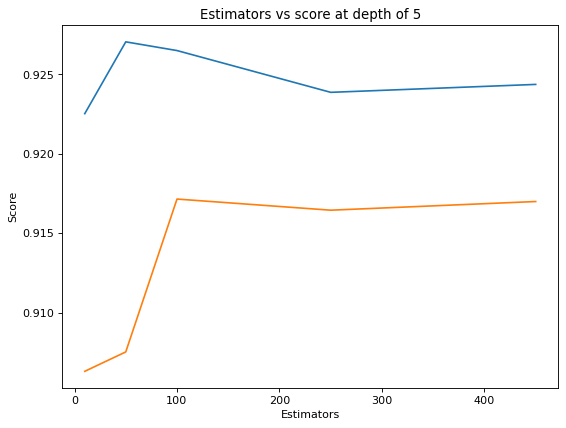

In [25]:
from matplotlib.pyplot import figure

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
figure(figsize=(8, 6), dpi=80)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8728464198905677 test Score 0.8558895066018068
depth =  9 Train Score 0.958626185027787 test Score 0.9221440493545456
depth =  11 Train Score 0.9612455265653197 test Score 0.9225178016776893
depth =  15 Train Score 0.964502411714918 test Score 0.9236825396825397
depth =  20 Train Score 0.964998777605737 test Score 0.9239066068860502
depth =  35 Train Score 0.9650510776257569 test Score 0.9238746269920214
depth =  50 Train Score 0.9650510776257569 test Score 0.9238746269920214
depth =  70 Train Score 0.9650510776257569 test Score 0.9238746269920214
depth =  130 Train Score 0.9650510776257569 test Score 0.9238746269920214


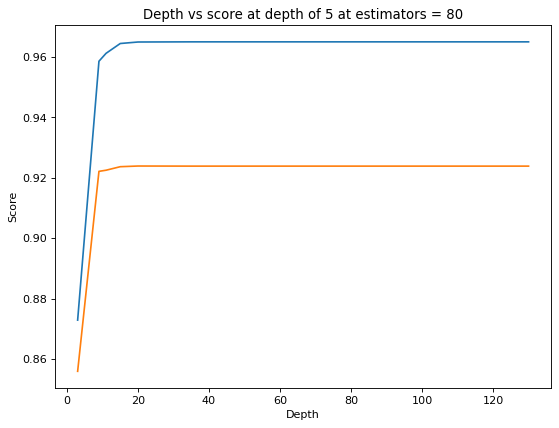

In [26]:

depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
figure(figsize=(8, 6), dpi=80)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 80')
plt.show()

In [27]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(50,100),
              "max_depth": sp_randint(10,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96357535 0.96338327 0.96368489 0.9653741  0.96473123]
mean train scores [0.96435035 0.96418655 0.96450936 0.96642749 0.96592276]


In [28]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=17, min_samples_leaf=28, min_samples_split=165,
                       n_estimators=53, n_jobs=-1, random_state=25)


In [29]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=72, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [30]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [31]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9661447442240017
Test f1 score 0.9243326902283375


#### Confusion Matrix

In [32]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("red")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


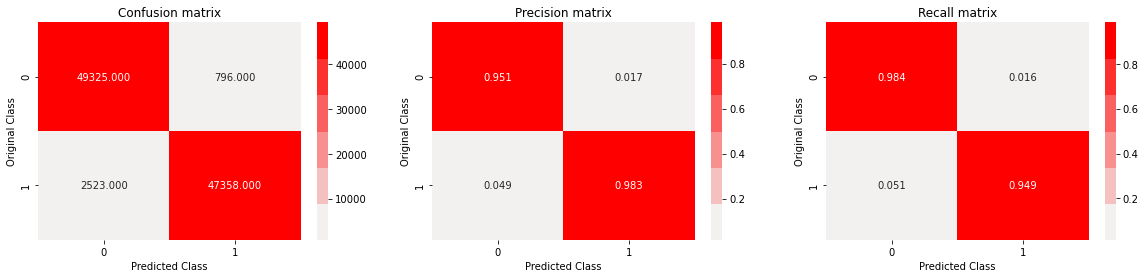

Test confusion_matrix


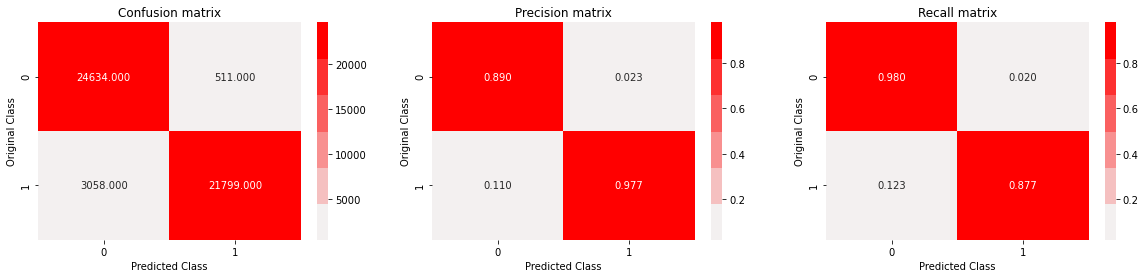

In [33]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

#### AUC-ROC curve

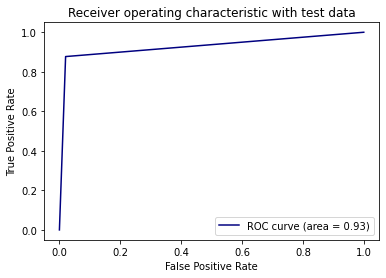

In [34]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

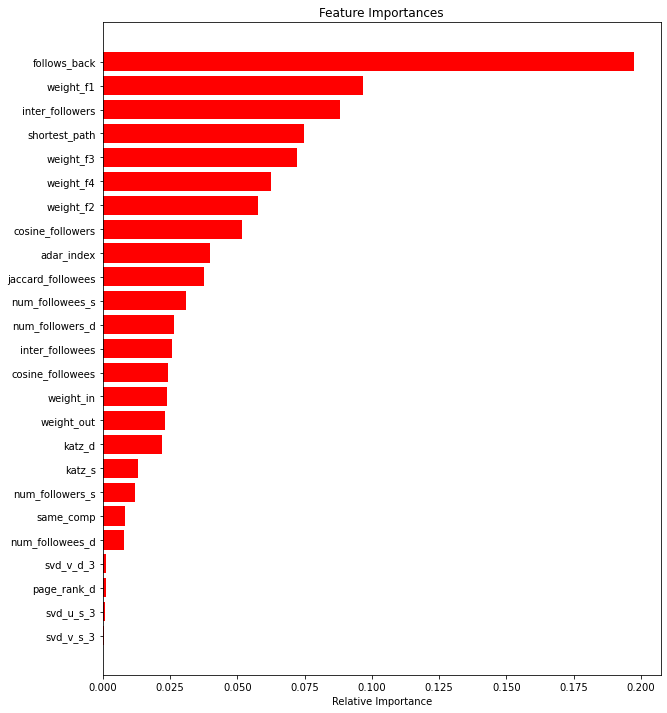

In [35]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## XG Boost

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(50,100),
              "max_depth": sp_randint(10,20)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,binary:logistic,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])

In [37]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=76, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [43]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=76, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

[00:43:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.923852446760792


#### Confusion Matrix

Train confusion_matrix


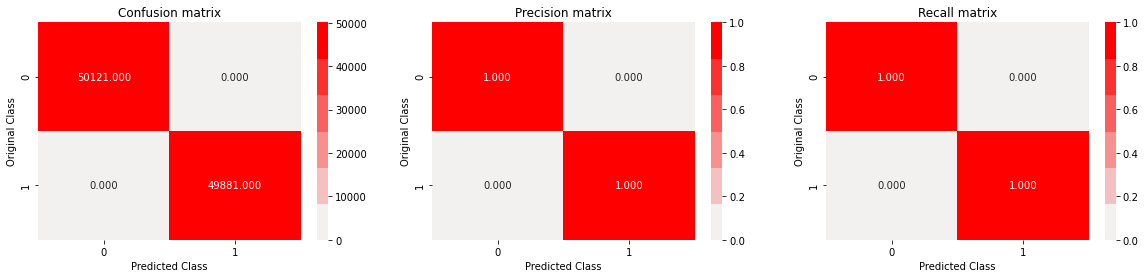

Test confusion_matrix


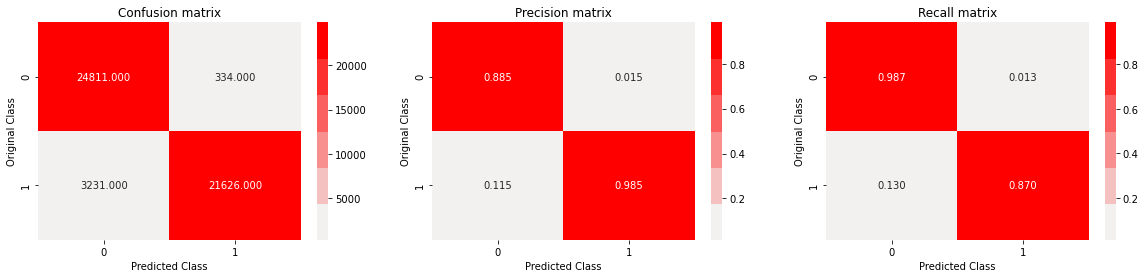

In [46]:

print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

#### AUC ROC curve

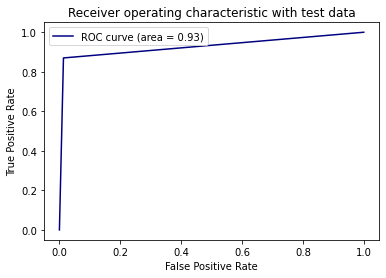

In [47]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

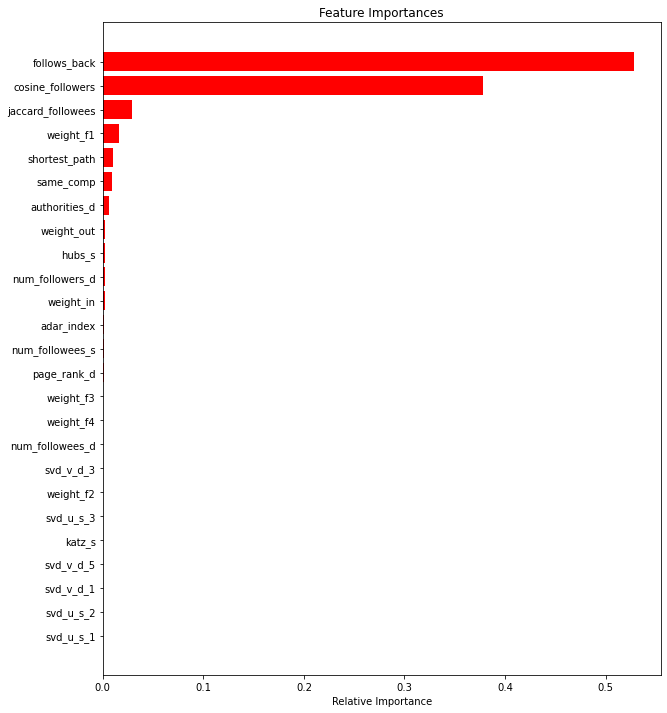

In [48]:
#feature importance

features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


### OBSERVATIONS

1. Understanding of graph and feature engineering was the most important part of this project.
2. For Random Forest, Follow_back was the most important feature found, followed by weight_f2 and shortest_path.
3. Best result was obtained in case of XGBOOST.
4. For XGBOOST, follows_back was the most important feature. Followed by cosine_follower and weight_f1.
5. XGBOOST gave the best result.